# init

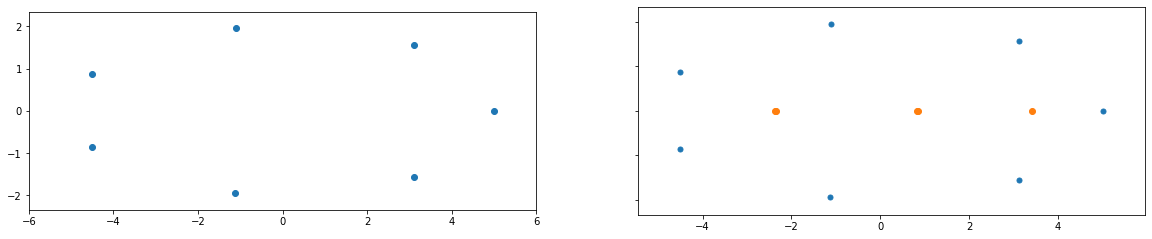

In [1]:
import sys 
sys.path.append('pyfiles/')
import classes as cl
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 
import csv 

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies.

points = cl.ellipse_example(numpts = 7)

[5.84, 0.42, 16.19, 53.31, 56.9, 24.07, 6.7]


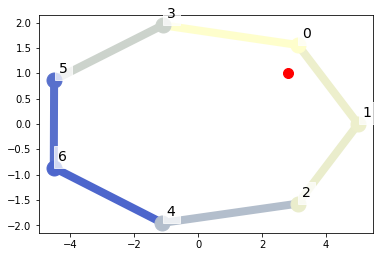

In [2]:
init_complex = cl.initcomplex(points)
s_complex = cl.complex()
s_complex.key_point = (2.8,1)

# update this to .self so don't need input, except maybe key pt
distlist = s_complex.find_sq_dist(init_complex)
cl.sort_complex(s_complex, distlist, plot = True)

# this is the permutation
all_simplices = s_complex.order_all_simps()
# I am pretty sure the simps are also ordered in s_complex, 
# not just all_simplices. make sure.
# dummy_simplex = cl.simplex()
# dummy_simplex.columnvalue = 0
# all_simplices.append(dummy_simplex)

In [69]:
mat = cl.bdmatrix()
mat.make_matrix(s_complex)

mat.redmatrix = mat.reduce(display = False)

# this adds in a column for reduced homology
mat.add_dummy_col()
# do smart thing to get rid of all_simplices
# maybe keep a list on the complex class?
mat.find_lows_zeros(all_simplices)

print("Zero Columns:")
for key, value in mat.zerocolumns.items():
    print(key, ":", value)
print("\nLowest Ones:")
for key, value in mat.lowestones.items():
    print(key, ":", value)
    

betti_dummy, betti_zero, betti_one = mat.find_bettis()

print("dummy: ", betti_dummy, "\nzero: ", betti_zero, "\none:" ,betti_one)
# print(all_simplices)

## ISSUE?!? I don't think col 14 would only have index of 4. 
# Should be 6, right?!
# print(all_simplices)
# ah, should be fine bc is initialization index, not ordered.

# ANOTHER ISSUE
# here, col index should be -1 if it's the emptyset, fix this

columns:  15  rows:  15
Zero Columns:
col : [0, 2, 4, 6, 8, 10, 12, 14]
dim : [-1, 0, 0, 0, 0, 0, 0, 1]
col_index : [0, 0, 6, 2, 5, 3, 4, 4]

Lowest Ones:
col : [1, 3, 5, 7, 9, 11, 13]
row : [0, 2, 4, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 0]
col_index : [1, 0, 6, 1, 5, 2, 3]
row_index : [-1, 0, 6, 2, 5, 3, 4]
dummy:  0 
zero:  0 
one: 1


In [71]:
bd_pairs = {
    # initial index. we can't differentiate vert/edge this way,
    # but we can by knowing classdim, so it's fine.
    "birth": [],
    "death": [],
    # always the dim of the 
    # birth simplex. 
    # the death simplex has dim +1 from birth. 
    "classdim": [],
    "b_simplex": [],
    "d_simplex": []
}
unpaired = {
    # classdim is the same as dim of birth simplex.
    # this is needed also so we know if it's a vert or edge,
    # since the index alone doesn't tell us.
    "birth": [],
    "classdim": [],
    "b_simplex": []
}

# we've counted birth death pairs, but now we
# need to add in inf persistence (unpaired)
died = True
i = 0
j = 0
for c in mat.zerocolumns["col"]:
    # this was the birth of an h class, so check if 
    # it is in row of lowest ones
    died = False
    for r in mat.lowestones["row"]:
        if r == c:
            died = True
            j += 1
    print("h class from simplex",i,
          "died" if died else "didn't die")
    if died and j < len(mat.lowestones["row"]): 
        # recheck if all the dims are right. 
        # might have mixed up rows and cols.
        bd_pairs["classdim"].append(mat.zerocolumns["dim"][i])
        bd_pairs["death"].append(mat.lowestones["row"][j])
        bd_pairs["birth"].append(mat.zerocolumns["col_index"][i])
        if mat.zerocolumns["dim"][i] == -1:
            bd_pairs["b_simplex"].append("emptyset")
            bd_pairs["d_simplex"].append("vert")
        if mat.zerocolumns["dim"][i] == 0:
            bd_pairs["b_simplex"].append("vert")
            bd_pairs["d_simplex"].append("edge")
        if mat.zerocolumns["dim"][i] == 1:
            bd_pairs["b_simplex"].append("edge")
    if died == False:
        # check here too.
        unpaired["birth"].append(mat.zerocolumns["col_index"][i])
        unpaired["classdim"].append(mat.zerocolumns["dim"][i])
        if mat.zerocolumns["dim"][i] == -1:
            unpaired["b_simplex"].append("emptyset")
        if mat.zerocolumns["dim"][i] == 0:
            unpaired["b_simplex"].append("vert")
        if mat.zerocolumns["dim"][i] == 1:
            unpaired["b_simplex"].append("edge")
    i = i + 1
# print("\n",bd_pairs, "\n\n", unpaired)

h class from simplex 0 died
h class from simplex 1 died
h class from simplex 2 died
h class from simplex 3 died
h class from simplex 4 died
h class from simplex 5 died
h class from simplex 6 died
h class from simplex 7 didn't die


In [72]:
print("birth death pairs")
for keys, value in bd_pairs.items():
   print(keys, value)
print("\n") 
print("infinite homology classes")
for keys, value in unpaired.items():
   print(keys, value)

# ISSUE: emptyset has index 0 ad we should index 
# it -1 for no confusion. find where index is given

birth death pairs
birth [0, 0, 6, 2, 5, 3]
death [2, 4, 6, 8, 10, 12]
classdim [-1, 0, 0, 0, 0, 0]
b_simplex ['emptyset', 'vert', 'vert', 'vert', 'vert', 'vert']
d_simplex ['vert', 'edge', 'edge', 'edge', 'edge', 'edge']


infinite homology classes
birth [4]
classdim [1]
b_simplex ['edge']


In [89]:
list = [1,3,4]
range(len(list))

range(0, 3)

In [91]:
for i in range(len(bd_pairs["birth"])):
    print(bd_pairs["b_simplex"][i], 
          bd_pairs["birth"][i], 
          "birthed a",
          bd_pairs["classdim"][i], 
          "h class killed by",
          bd_pairs["d_simplex"][i], 
          bd_pairs["death"][i], 
         )
for i in range(len(unpaired)):
    print(unpaired["b_simplex"][i],
          unpaired["birth"][i],
          "birthed an infinite",
          unpaired["classdim"][i],
          "h class"
         )

emptyset 0 birthed a -1 h class killed by vert 2
vert 0 birthed a 0 h class killed by edge 4
vert 6 birthed a 0 h class killed by edge 6
vert 2 birthed a 0 h class killed by edge 8
vert 5 birthed a 0 h class killed by edge 10
vert 3 birthed a 0 h class killed by edge 12
edge 4 birthed an infinite 1 h class


IndexError: list index out of range

In [33]:
# next: print out, 
# simplex i caused birth of _ homology class, etc
# I think that when there's a lowest one, you take the row value: 
# it gave birth, and the column value gave death.
# the dimension of the class is the birth dim.

# is our pairing consistent with the elder rule? 
# it just follows from the matrix, right? 
# and the pairing lemma? 
i = 0
for c in range(len(mat.lowestones["col"])):
    print("vertex" if mat.lowestones["dim"][i] == 0 
          else "ldfjks", 
          mat.lowestones["row_index"][i], 
          "gave birth to a", mat.lowestones["dim"][i],
          "h class killed by",
          "vertex" if mat.lowestones["dim"][i] + 1 == 0 else "ldfjks", 
          mat.lowestones["col_index"][i])
    i += 1
    
# We are missing the birth of the 1-cycle, because it is not killed
# so it is not a lowest one.

# I think next, we need to go over all zero-columns in the matrix.
# that simplex gave birth to an h-class. 
# so we check the corresponding row, and see it is already matched 
# with a lowest one. If it's not, then it birthed a class that was never
# killed, and we need to add it to the list.

ldfjks -1 gave birth to a -1 h class killed by vertex 1
vertex 0 gave birth to a 0 h class killed by ldfjks 0
vertex 6 gave birth to a 0 h class killed by ldfjks 6
vertex 2 gave birth to a 0 h class killed by ldfjks 1
vertex 5 gave birth to a 0 h class killed by ldfjks 5
vertex 3 gave birth to a 0 h class killed by ldfjks 2
vertex 4 gave birth to a 0 h class killed by ldfjks 3


# ask herbert: 
1. can we guarantee there is always a lowest one in row 0? 
    I am pretty sure this is guaranteed if the simp cplx isn't empty, because there is always an empty set and it always gets killed immediately, right? relevant in 
    ```
        # I am pretty sure it is always first
        # I am also pretty sure there is always a 1 in row one
        self.lowestones["row_index"].append(-1)
        for j in range(length):
            # we know it's a square matrix by construction 
            for i in range(length):
    ```
    roughly l429, in find_lows_zeros(self,all_simps)
2. alskfjdslkfj